# Creating EOPatches from JP2 files

- Bbox_splitter: creation of the bounding boxes corresponding to the eopatches that will be created for the entire region of Pergamino.
- JP2toEOP: the task "ImportFromJP2" will allow us to load data from JP2 files into the eopatches.
- GDF for k-folding: for future tasks (k-cross validation) we need to create a special geodataframe.

In [1]:
from scipy import stats
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from enum import Enum
from tqdm import tqdm 
from contextlib import contextmanager  

import geopandas as gpd
from shapely.geometry import Polygon

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from rasterio import plot
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.crs

from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor, SaveTask 
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.io.local_io import *
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask, AddMultiCloudMaskTask
from eolearn.mask.utilities import resize_images
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, InterpolationTask, ValueFilloutTask, \
    HaralickTask, AddMaxMinNDVISlopeIndicesTask, AddMaxMinTemporalIndicesTask, AddSpatioTemporalFeaturesTask, \
    HOGTask, MaxNDVICompositing, LocalBinaryPatternTask

from fd.jp2_to_EOP import (import_jp2,get_val_mask)

### Workflow for reading data

In [2]:
### Paths

## Path to jp2000 files
path_jp2 = '/data-id/lscalambrin/scenes/camp1819'

## Path to area of interest shapefile
#AOI Pergamino
# path_shapes = '/data-id/lscalambrin' + '/vectores/LotesDibujados/Pergamino'
#AOI Gral Lopez
path_shapes = '/data/lscalambrin/proyecto_integrador/extras/felix/desafioAgtech/data/dataset'

## Path to save new eopatches
save_patch = '/data-id/lscalambrin/proyecto_integrador/segmentation/gral_lopez/eopatches2'

## Bad data from Pergamino or Gral Lopez
bad_data_pergamino = ['20180109T135101','20180325T135109','20180208T135111','20180320T135111',
           '20171110T135111','20171225T135059','20180315T135109','20171115T135059',
           '20171130T135111','20171016T135059','20180104T135059','20170911T135111','20171215T135059',
           '20180330T135111','20180310T135111', '20180102T140051']


bad_data_gral_lopez = ['20181007T141039','20181121T141041','20190105T141049','20181201T141041','20181226T141039'] # All from HNH


add_data = import_jp2((FeatureType.DATA, 'BANDS'), path_jp2, bad_data_gral_lopez)

cloud_classifier = get_s2_pixel_cloud_detector(average_over=2, dilation_size=1, all_bands=True)

add_clm = AddCloudMaskTask(
                            cloud_classifier, 'BANDS', cm_size_y='80m', cm_size_x='80m', 
                           cmask_feature='CLM', # cloud mask name
                           cprobs_feature='CLP' # cloud prob. map name
                          )

add_sh_valmask = get_val_mask()

# TASK FOR SAVING TO OUTPUT
save = SaveTask(save_patch, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

workflow = LinearWorkflow(add_data, 
                          add_clm, 
                          add_sh_valmask,
                          save)


/home/lscalambrin/miniconda3/envs/deep_crop/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/lscalambrin/miniconda3/envs/deep_crop/lib/python3.8/site-packages/eolearn/mask/cloud_mask.py:86: SHDeprecationWarning: AddCloudMaskTask is being deprecated. Please use AddMultiCloudMaskTask instead. See showcase at examples/mask/CloudMaskTask.ipynb
  warnings.warn("AddCloudMaskTask is being deprecated. Please use AddMultiCloudMaskTask instead. "


### Bbox creation
Here we create all the Bounding boxes which correspond to the EOPatches that will be used for the segmentation of Pergamino. There are 32 EOPatches covering the entire region.

In [4]:
## AOI shapefile
#For Gral Lopez
pergamino_gpdf = gpd.read_file(path_shapes+'/Gral Lopez.shp')
#For Pergamino
# pergamino_gpdf = gpd.read_file(path_shapes+'/20180228_Completo_32720.shp')

pergamino_crs = CRS.UTM_20S
pergamino_gpdf = pergamino_gpdf.to_crs(crs={'init': CRS.ogc_string(pergamino_crs)})
pergamino_gpdf.geometry = pergamino_gpdf.buffer(0.1)
pergamino = pergamino_gpdf.geometry.unary_union.buffer(380)

bbox_splitter_complete = BBoxSplitter([pergamino], pergamino_crs, (1,1)) # 6 x 6 pergamino
bbox_complete = bbox_splitter_complete.get_bbox_list()

tmp = bbox_complete[0].get_partition(size_x = 12630, size_y = 11890)
tmp = np.asarray(tmp)

bbox_list = []
info_list = []
for i in range(tmp.shape[0]):
    for j in range(tmp.shape[1]):
        if bbox_splitter_complete._intersects_area(tmp[i][j]):
            bbox_list.append(tmp[i][j])
            info_list.append({'parent_bbox': bbox_complete[0], 'index_x': i, 'index_y':j})

info_list = np.asarray(info_list)
bbox_list = np.asarray(bbox_list)

# Create patchIDs
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)
    
# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs={'init': CRS.ogc_string(pergamino_crs)}, 
                       geometry=geometry)

/home/lscalambrin/miniconda3/envs/deep_crop/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Plot of AOI and eopatches to be created

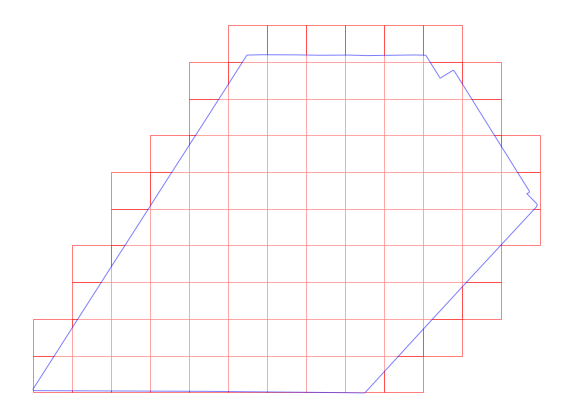

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
pergamino_gpdf = gpd.GeoDataFrame(geometry=[pergamino])
pergamino_gpdf.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
# ax.set_title('EOPatches Area of Interest', size=18);
plt.axis('off')
plt.show()

### Execution of workflow

In [7]:
### args for the workflow

execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'eopatch': EOPatch(bbox=bbox)},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    });

/home/lscalambrin/miniconda3/envs/deep_crop/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
len(execution_args)

97

#### Individual execution

In [9]:
for i in range(len(execution_args)):
    if i<1:
        print(f'--- comenzando: {i}')
        eop = workflow.execute(execution_args[i])
        print(f'{i}: finalizado')

--- comenzando: 0
tiles available: ['T20HNH' 'T20HPH']
--------------------- date: 0, 20181004T140049
--> bad_data: 20181007T141039
--------------------- date: 1, 20181009T140051
date: 20181009T140051 removed
--------------------- date: 2, 20181014T140049
date: 20181014T140049 removed
--------------------- date: 3, 20181103T140049
--------------------- date: 4, 20181108T140051
date: 20181108T140051 removed
--------------------- date: 5, 20181118T140051
--> bad_data: 20181121T141041
--------------------- date: 6, 20181123T140049
--------------------- date: 7, 20181128T140041
--> bad_data: 20181201T141041
--------------------- date: 8, 20181203T140049
date: 20181203T140049 removed
--------------------- date: 9, 20181208T140041
--------------------- date: 10, 20181223T140049
--> bad_data: 20181226T141039
--> bad_data: 20190105T141049
--------------------- date: 11, 20190206T140051
--------------------- date: 12, 20190216T140051
--------------------- date: 13, 20190226T140051
-------------

## gdf for the future
This geodataframa file is then use for the k-folding process (notebook 07).

In [13]:
eop_list = [f'eopatch_{idx}' for idx in range(len(execution_args))]
data = {'name': eop_list} 

gdf_grid_eop = gpd.GeoDataFrame(data) 
gdf_grid_eop['geometry'] = gdf['geometry']
gdf_grid_eop.head()

gdf_grid_eop.to_file("./gral_lopez/grid_eop.gpkg", driver="GPKG")

In [1]:
# gdf_grid_eop.to_file("./gral_lopez/grid_eop_s.gpkg", driver="GPKG")